#  Lunar Lander with Least Squares Policy Iteration (LSPI) :

Author: Nirav Lad

This notebook implements [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) as available through [Farama Foundation Gymnasium](https://gymnasium.farama.org/).  The algorithm utilized is [LSPI](https://www.jmlr.org/papers/volume4/lagoudakis03a/lagoudakis03a.pdf) with a some differences as noted (e.g. weight updates) from the paper by [Lagoudakis](https://scholar.google.com/citations?user=VqHiIg8AAAAJ) and [Parr](https://scholar.google.com/citations?user=b-GJ3QIAAAAJ).

## Import libraries

In [1]:
try:
    import google.colab
    from IPython.display import clear_output
    !apt-get install swig
    !pip install swig
    !pip install gymnasium[box2d]
    !pip install moviepy==2.2.1
    clear_output(wait=True)
except ImportError:
    pass

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import gymnasium as gym

from typing import List, Tuple, Union, Callable
from numpy.typing import NDArray
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import seaborn as sns

from gymnasium.wrappers import RecordVideo
from moviepy import VideoFileClip, TextClip, CompositeVideoClip, concatenate_videoclips
from IPython.display import Video
import os
import shutil

## Define parameters

### Enviroment variables

In [3]:
ENV_NAME = 'LunarLander-v3'

In [4]:
env = gym.make(ENV_NAME)
SLOW = env.observation_space.low
SHIGH = env.observation_space.high
SRANGE = SHIGH - SLOW
cardS = len( env.observation_space.low )
A = np.arange( env.action_space.n )
cardA = len(A)
env.close()

num_best_policies = 10

### Hyperparameters

In [5]:
Δ = 1e-6
γ = 0.999
lr = (0.5, 0.5)

## Functions

### Helper functions

In [6]:
def calculate_mean_hw( d: Union[List[np.float32] | NDArray[np.float32]], ci:int = 0.95 ) -> Tuple[np.float32, np.float32]:
    d = np.array( d )
    n = np.size( d )
    std_error = np.std( d, ddof=1 ) / np.sqrt(n)
    t_critical = stats.t.ppf( 1 - ( 1 - ci ) / 2, n - 1 )
    mean = np.mean( d ) 
    halfwidth = t_critical * std_error
    return( mean, halfwidth )

In [7]:
def record_policy( w:NDArray[np.float32], 
                   φ:Callable[[NDArray[np.float32], int],int],
                   title:str, 
                   M:int = 10, 
                   seed:int = 1776,
                   enable_wind = False ) -> str:

    import warnings
    warnings.filterwarnings("ignore", message=".*Overwriting existing videos.*")
    os.makedirs("videos", exist_ok=True)
    env = gym.make(ENV_NAME, render_mode="rgb_array", enable_wind=enable_wind)
    env = RecordVideo(env, video_folder="videos", episode_trigger=lambda ep: True)

    G = []

    for m in np.arange(M):

        Gm = 0
        s,_ = env.reset( seed = int( seed * 1e2 + m * 3e4 ) )
        terminated = False
        truncated = False
        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r
        
        G.append( Gm )

    μ, δ = calculate_mean_hw( G )
    score = μ - δ

    env.close()

    video_files = sorted([f for f in os.listdir("videos") if f.endswith(".mp4")])
    annotated_clips = []
    for i, vf in enumerate(video_files):
        clip = VideoFileClip(f"videos/{vf}", )
        
        txt = TextClip( text=f"{title}\nEP {i+1:2d} Reward: {G[i]:0.1f}\nScore: {score:0.1f} ({μ:0.1f} ± {δ:0.1f})", 
                        font_size=14, 
                        color='white', 
                        method='caption',
                        vertical_align='left', horizontal_align='top',
                        size = (clip.w, 60) )
        txt = txt.with_duration(clip.duration)
        
        annotated_clip = CompositeVideoClip([clip, txt])
        annotated_clips.append(annotated_clip)

    final_clip = concatenate_videoclips(annotated_clips )

    fname = f"best_policy_({score:0.1f}).mp4"
    final_clip.write_videofile(fname)

    shutil.rmtree("videos")

    return( fname )

### Basis functions

Each row of $\Phi$ contains the value of all basis functions for a certain pair $(s,a)$ and each
column of $\Phi$ contains the value of a certain basis function for all pairs $(s,a)$. Using the indicator function $I$ then we have $\Phi(s,a) = \begin{pmatrix} \phi(s,a)\times I(a=1), \cdots, \phi(s,a)\times I(a=k)\end{pmatrix}^{\intercal}$

In [8]:
def Φ( state:NDArray[np.float32], action:int, φ:Callable[[NDArray[np.float32], int], int] ) -> NDArray[np.float32]:
    return( np.hstack([ φ(state, action ) * ( a == action ) for a in A ]) )

### Poilicy function ($\pi$)

$\pi(s) =\arg \max_{a \in \mathcal{A}} \Phi(s,a)^{\intercal} w$

In [9]:
def π( state:NDArray[np.float32], w:NDArray[np.float32], φ:Callable[[NDArray[np.float32],int],int] ) -> int:
    return( np.argmax( [ np.dot( Φ( state, a, φ ), w ) for a in A ]) )

### TD Learning rate

The learning rate at episode $n$ with initial learnign rate $\alpha_a$ and learning rate decay $\alpha_b$ is defined as $\alpha_n =  a_{a}\left( \frac{1}{(1 + n)^{\alpha_{b}}} \right)$

In [10]:
def α( n:int ) -> float:
    α_init, α_decay = lr
    return( α_init / (n + 1)**α_decay )

### Generate random samples

In [11]:
def Samples( w:NDArray[np.float32], 
             φ:Callable[[NDArray[np.float32], int],int],
             seed:int = 42, 
             enable_wind:bool = False ) -> List[Tuple]:

    env = gym.make( ENV_NAME, enable_wind = enable_wind )

    np.random.seed( int( seed * 1e3 ) )

    samples = []

    for _ in range(1):
        terminated = False
        truncated = False

        s = env.reset( seed = int( seed * 1e3 ) )[0]

        while not( terminated or truncated ):
            a = π( s, w, φ )  

            sP, r, terminated, truncated, _ = env.step( a )
            samples.append( (s, a, r, sP, terminated) )
            s = sP

        env.close()

    return( samples )

### Evaluate policy

In [12]:
def evaluate_policy( w:NDArray[np.float32], 
                     φ:Callable[[NDArray[np.float32], int],int],
                     num_evaluations:int = 10, 
                     seed:int = 42, 
                     enable_wind:bool = False ) -> Tuple[float, float]: 

    env = gym.make( ENV_NAME, enable_wind = enable_wind )

    G = []

    for n in np.arange( num_evaluations ):
        terminated = False
        truncated = False

        Gm = 0
        s = env.reset( seed = int( seed * 1e2 + n * 3e4 ) )[0]

        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r

        G.append( Gm )

    μ, δ = calculate_mean_hw( G )

    return ( μ, δ )

### **LSTDQ**-opt

Implementation of <b>LSDQ</b>-opt that utilizes the [Sherman-Morris formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) to compute the "rank-1 update" for matrix inversion. This allows computation in $O(n^2)$ as opposed to $O(n^3)$. Note the implementation utilizes smoothing via a difference update.

<b>Inputs</b>:
- $D$: Source of samples $(s,a,r,s')$
- $k$: Number of basis functions
- $\Phi$: Basis functions
- $\gamma$: Discount factor
- $\pi$: Policy whose value function is sought

<b>algorithm</b>:<br>
1: $\mathbf{B} \gets \frac{1}{\Delta} \mathbf{I} \;\;$ is a $(k \times k)$ matrix<br>
2: $b \gets \mathbf{0} \;\;$ is a $(k \times 1)$ matrix<br>
3: <b>for each</b> $(s,a,r,s') \in D$<br>
4: &nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{B} \gets \mathbf{B} - \frac{ \mathbf{B}\Phi(s,a)\left( \Phi(s,a) - \gamma \Phi(s', \pi(s')) \right)^{\intercal} \mathbf{B} }{ 1 + \left( \Phi(s,a) - \gamma \Phi(s',\pi(s')) \right)^5: {\intercal} \mathbf{B} \Phi(s,a)}$<br>
5: &nbsp;&nbsp;&nbsp;&nbsp;$b \gets b + \Phi(s,a)r$<br>
6: $\tilde{w}^{\pi} \gets \mathbf{B}b$ results in a $(k \times 1)$ matrix<br>
7: <b>return<b> $\tilde{w}^{\pi}$

In [13]:
def LSTDQ_opt( D:List[Tuple], 
               k:int,
               w:NDArray[np.float32], 
               φ:Callable[[NDArray[np.float32], int], int], 
               n:int ) -> NDArray[np.float32]:

    B = np.eye( k ) * Δ
    b = np.zeros( k )
    A = np.zeros((k,k))

    for ( s, a, r, sP, terminated ) in D:

        Φ_sa = Φ( s, a, φ ).flatten()
        Φ_sPaP = Φ( sP, π( sP, w, φ ), φ ).flatten() * ( 1 - terminated ) 
        
        u = B @ Φ_sa
        v = ( Φ_sa - γ * Φ_sPaP ).T @ B
        
        #A = A + np.outer( Φ_sa, Φ_sa - γ * Φ_sPaP  )
        B = B - np.outer( u, v ) / ( 1 + v @ Φ_sa )
        b = b +  r * Φ_sa
    
    wP = B @ b.T
    #wP = np.linalg.solve( A + B, b.T )
    wP = np.asarray( wP ).ravel()

    w = ( 1 - α(n) ) * w + ( α(n) )* wP

    return( w )

### **LSPI**

The stopping criteria for this implementation is stopping after $M$ episodes. Additionally, the function returns all training policies for later evaluation rather than the superlative policy $w^*$.

<b>Inputs</b>:
- $D$: Source of samples $(s,a,r,s')$
- $k$: Number of basis functions
- $\Phi$: Basis functions
- $\gamma$: Discount factor
- $\epsilon$: Stopping criterion
- $\pi_0$: Initial policy, given as $w_0$ (default $w_0 = \mathbf{0}$)

<b>algorithm</b>:<br>
1: $\pi' \gets \pi_0$<br>
2: <b>repeat</b><br>
3: &nbsp;&nbsp;&nbsp;&nbsp;$\pi \gets \pi'$<br>
4: &nbsp;&nbsp;&nbsp;&nbsp;$\pi' \gets$ <b>LSTDQ</b> $(D,k,\Phi, \gamma, \pi)$<br>
5: <b>until</b>$(\pi \approx \pi')$ <br>
6: <b>return<b> $\pi$

In [14]:
def LSPI( w:NDArray[np.float32], 
          k:int, 
          φ:Callable[[NDArray[np.float32], int], int], 
          M:int = 500, 
          seed:int = 0, 
          enable_wind:bool=False ) -> pd.DataFrame:

    d = []

    for m in tqdm( np.arange(M) ):

        D = Samples( w, φ, seed=( m + seed ), enable_wind=enable_wind )

        w = LSTDQ_opt( D, k, w, φ, m )
        
        μ, δ = evaluate_policy( w, φ, seed = m, enable_wind=enable_wind, num_evaluations=10 )

        score = μ - δ

        tqdm.write(f"Episode{m:3d}:\t{score:.2f}\t({μ:3.2f} ± {δ:3.2f})")
        d.append({'episode':m, 'score': score, 'mean': μ, 'halfwidth': δ, 'w': w.copy()})

    policies = pd.DataFrame( d )

    return( policies )

## Run **LSPI**

### Basis Function

In [15]:
def simple( state:NDArray[np.float32], action:int ) -> NDArray[np.float32]:
    return( np.hstack( ( state ) ) )

In [16]:
def interactions( state:NDArray[np.float32], action:int ) -> NDArray[np.float32]:

    px, py, vx, vy, θ, ω, lf, rf = state

    state_interactions = np.array([px*py, px*vx, px*θ, px*ω, px*lf, px*rf,
                                   py*vx, py*vy, py*θ, py*ω, py*lf, py*rf,
                                   vx*vy, vx*θ, vx*ω, vx*lf, vx*rf,
                                   vy*θ, vy*ω, vy*lf, vy*rf,
                                   θ*ω, θ*lf, θ*rf,
                                   θ*lf, θ*rf,
                                   lf*rf])
    
    return( np.hstack( ( state, state_interactions ) ) )

In [17]:
bf = interactions

In [18]:
k = len( Φ(np.zeros(cardS), A[0], bf) )
w = np.zeros( k )
seed=1982
policies = LSPI( w, k, bf, M=300, seed=seed, enable_wind=False )

  0%|          | 0/300 [00:00<?, ?it/s]

Episode  0:	-594.42	(-509.93 ± 84.49)
Episode  1:	-421.42	(-277.76 ± 143.65)
Episode  2:	-456.37	(-257.23 ± 199.14)
Episode  3:	-58.94	(15.96 ± 74.89)
Episode  4:	-5.45	(73.32 ± 78.77)
Episode  5:	-24.73	(73.69 ± 98.42)
Episode  6:	-97.65	(-1.08 ± 96.57)
Episode  7:	-97.72	(-8.42 ± 89.30)
Episode  8:	-95.07	(-70.44 ± 24.64)
Episode  9:	-140.85	(-79.48 ± 61.37)
Episode 10:	-162.87	(-143.26 ± 19.61)
Episode 11:	-196.26	(-61.68 ± 134.58)
Episode 12:	-145.89	(48.02 ± 193.91)
Episode 13:	-693.90	(-583.72 ± 110.18)
Episode 14:	-485.16	(-367.13 ± 118.03)
Episode 15:	-229.04	(-189.49 ± 39.55)
Episode 16:	-259.32	(-213.39 ± 45.94)
Episode 17:	-248.22	(-187.83 ± 60.39)
Episode 18:	-115.24	(-80.04 ± 35.20)
Episode 19:	-79.23	(38.05 ± 117.28)
Episode 20:	-71.91	(43.08 ± 114.99)
Episode 21:	-617.37	(-481.63 ± 135.74)
Episode 22:	-99.41	(35.22 ± 134.62)
Episode 23:	3.16	(126.42 ± 123.27)
Episode 24:	37.31	(118.50 ± 81.18)
Episode 25:	-152.68	(1.76 ± 154.44)
Episode 26:	-193.23	(-87.58 ± 105.65)
Epis

### Plot learning curve

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_25879/2461744452.py:3: SyntaxWarning: invalid escape sequence '\m'
  sns.lineplot(data=policies, x='episode', y='mean', label="$\mu$")


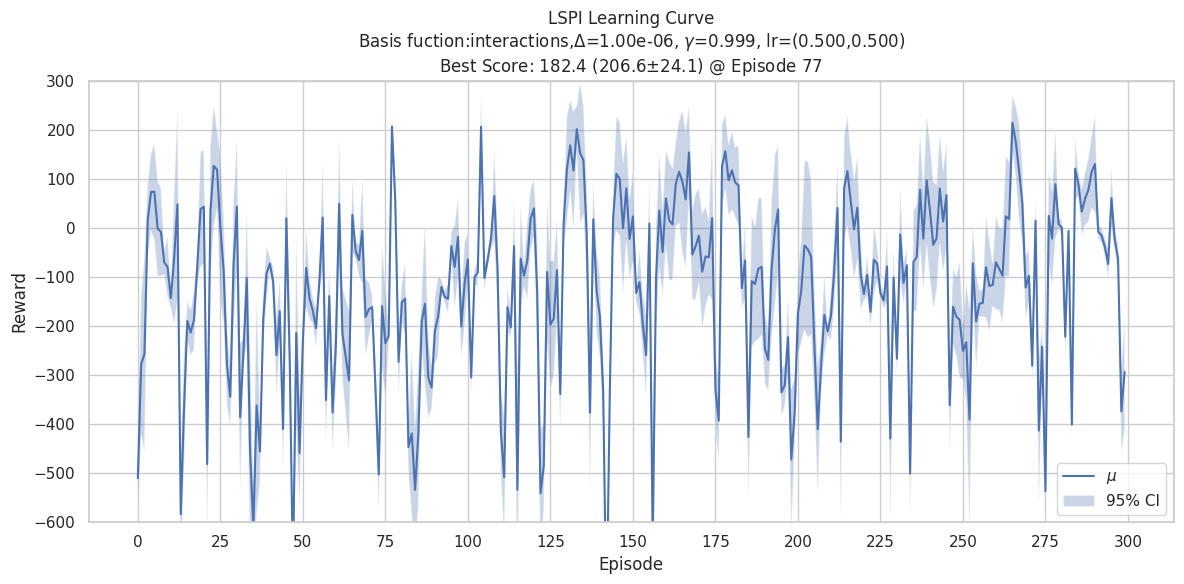

In [19]:
plt.figure(figsize=(12, 6))  
sns.set_theme(style="whitegrid") 
sns.lineplot(data=policies, x='episode', y='mean', label="$\mu$")
plt.fill_between( policies['episode'],
                  policies['mean'] - policies['halfwidth'],
                  policies['mean'] + policies['halfwidth'],
                  alpha=0.3,
                  label='95% CI')

policies.sort_values(by='score', ascending=False, inplace=True)
p = policies.iloc[0]

plt.title(f"LSPI Learning Curve\n" +\
          f"Basis fuction:{bf.__name__},$\\Delta$={Δ:.2e}, $\\gamma$={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})\n" + \
          f"Best Score: {p['score']:.1f} ({p['mean']:.1f}$\\pm${p['halfwidth']:.1f}) @ Episode {p['episode']}" )
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(-600, 300)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"learning_curve.pdf")

plt.show()

### Determine best policy ($w^*$)

In [20]:
best_score = -np.inf

print(f"EVALUATING TOP {num_best_policies} POLICES")
print("\t\tScore\t(μ ± δ)")
for i, p in policies.head(num_best_policies).iterrows():
    μ, δ = evaluate_policy(p['w'], bf, num_evaluations=30, seed=1776)
    score = μ - δ
    print(f"Episode {i:3d}\t{score:.1f}\t({μ:.1f} ± {δ:.1f})")
    if ( best_score < score ):
        best_score = score
        w_star = p['w']
        m_star = p['episode']

print(f"SUPERLATIVE POLICY:\tEPISODE {m_star}")

EVALUATING TOP 10 POLICES
		Score	(μ ± δ)
Episode  77	204.2	(216.8 ± 12.6)
Episode 265	146.3	(187.5 ± 41.2)
Episode 133	132.9	(171.6 ± 38.8)
Episode 104	147.8	(193.3 ± 45.5)
Episode 266	146.6	(181.7 ± 35.0)
Episode 178	55.4	(100.6 ± 45.3)
Episode 131	166.6	(195.7 ± 29.0)
Episode 285	86.6	(105.3 ± 18.7)
Episode 167	-22.4	(24.9 ± 47.4)
Episode 284	95.6	(123.6 ± 28.0)
SUPERLATIVE POLICY:	EPISODE 77


### The superlative policy $w^*$ weights

In [21]:
np.set_printoptions(precision=2)
print(f"w*:")
print( w_star.reshape(-1,4) )

w*:
[[ 6.55e-06 -3.44e-05  8.28e-06  6.00e-05]
 [-3.39e-05 -2.05e-05 -3.92e-06 -3.07e-06]
 [ 2.93e-07 -3.02e-05  1.82e-05  6.44e-06]
 [-6.05e-08  1.37e-06  1.59e-06  2.03e-05]
 [-5.32e-06 -4.32e-06  3.53e-08 -5.94e-08]
 [-9.05e-06  3.66e-05  1.21e-05 -2.99e-06]
 [ 1.21e-07  6.87e-05  3.55e-05  4.22e-06]
 [ 1.34e-06 -1.18e-04  4.48e-06 -9.52e-07]
 [ 4.48e-06 -9.52e-07 -2.03e-06  9.47e-06]
 [-3.67e-05  1.72e-05  3.87e-05 -3.51e-05]
 [-2.12e-05 -8.68e-06 -8.14e-06  6.14e-06]
 [-7.63e-06  8.45e-06  4.62e-06  2.16e-06]
 [ 2.03e-06  1.47e-05  2.65e-05 -2.76e-05]
 [-2.77e-05 -1.12e-06 -9.61e-07 -1.18e-05]
 [ 2.15e-05  2.58e-05  2.08e-07  1.51e-06]
 [ 4.68e-05  3.21e-05  5.35e-06  2.75e-06]
 [-1.08e-04  5.17e-06 -1.88e-06  5.17e-06]
 [-1.88e-06 -7.09e-06 -1.20e-05 -6.10e-05]
 [ 4.47e-07 -1.81e-05 -2.07e-05 -2.41e-05]
 [-9.57e-07 -6.40e-06 -1.14e-05 -2.25e-05]
 [ 1.12e-06 -2.35e-06  1.39e-06 -5.40e-07]
 [-7.19e-07 -1.88e-05 -1.57e-05 -2.40e-06]
 [ 1.85e-07  9.85e-08 -6.32e-06  4.61e-05]
 [ 1.53

### View video recording of the best policy

In [22]:
title = f"LSPI DELTA={Δ:.2e}, GAMMA={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})"
video_filename = record_policy( w_star, bf, title, enable_wind=False, seed=2031 )
print(f"Done! Video saved to {video_filename}")

MoviePy - Building video best_policy_(227.9).mp4.
MoviePy - Writing video best_policy_(227.9).mp4



MoviePy - Done !
MoviePy - video ready best_policy_(227.9).mp4
Done! Video saved to best_policy_(227.9).mp4


In [23]:
Video(video_filename, embed=True)